In [4]:
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.optim as optim
import torchvision
import torchvision.models as models
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import transforms
from PIL import Image
import os
import split_folders
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

get_ipython().run_line_magic('matplotlib', 'inline')

In [26]:
split_folders.ratio('/home/mluser/Documents/face recognition dataset', output="/home/mluser/Documents/output__dataset", seed=1337, ratio=(.8, .1, .1))

Copying files: 945 files [00:05, 159.89 files/s]


In [6]:
os.chdir("/home/mluser/Documents/output__dataset")
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [7]:
num_workers = 0
batch_size = 20

data_dir = "/home/mluser/Documents/output__dataset"

train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
valid_dir = os.path.join(data_dir, 'val/')

transform_train = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = torchvision.datasets.ImageFolder(train_dir,transform=transform_train)
valid_data = torchvision.datasets.ImageFolder(valid_dir,transform=transform_val)
test_data = torchvision.datasets.ImageFolder(test_dir,transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)

In [8]:
model= models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
for param in model.parameters():
    param.requires_grad = False
    model.fc = nn.Linear(2048, 30)
    
    fc_parameters = models = model.fc.parameters()
    for param in fc_parameters:
        param.requires_grad = True
        
    if use_cuda:
        model = model.cuda()
            
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model.fc.parameters(),lr=0.001)

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, scheduler=None, use_cuda=False, save_path="default.pt"):

    valid_loss_min = np.Inf
   
    for epoch in range(1, n_epochs+1):

#   if scheduler is not None:
#       scheduler.step()
        train_loss = 0.0
        valid_loss = 0.0
#       print('Epoch:', epoch,'LR:', scheduler.get_lr())

        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            preds = model(data)
            loss = criterion(preds,target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
           
            if batch_idx % 50 == 0:
                print('\rEpoch %d, Batch %d loss: %.6f' % (epoch, batch_idx + 1, train_loss))
           
           
        print("EPOCH ",epoch," Tr Loss: ",train_loss)

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()

            preds = model(data)
            loss = criterion(preds,target)#Your Dataset download has started.
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            if batch_idx % 50 == 0:
                print('\rEpoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, valid_loss))
                
                train_loss = train_loss/len(train_loader.dataset)
                valid_loss = valid_loss/len(valid_loader.dataset)
                       

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))
       

        if(valid_loss<valid_loss_min):
            print("Prev: ",valid_loss_min," Cur: ",valid_loss)
            print("Saving......")
            valid_loss_min = valid_loss
            torch.save(model.state_dict(),save_path)
            print("saved!")
            m=1
            if epoch%10==0:
                torch.save(model1(m).net)
                m=m+1
                
 

    return model

In [11]:
loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [14]:
epochs=20
model1=train(epochs,loaders,model,optimizer_resnet,criterion_resnet,use_cuda,"model1.pt")

Epoch 1, Batch 1 loss: 0.022349
EPOCH  1  Tr Loss:  tensor(0.0475, device='cuda:0')
Epoch 1, Batch 1 loss: 0.279247
Epoch: 1 	Training Loss: 0.000067 	Validation Loss: 0.369842
Prev:  inf  Cur:  tensor(0.3698, device='cuda:0')
Saving......
saved!
Epoch 2, Batch 1 loss: 0.020328
EPOCH  2  Tr Loss:  tensor(0.0517, device='cuda:0')
Epoch 2, Batch 1 loss: 0.478171
Epoch: 2 	Training Loss: 0.000073 	Validation Loss: 0.253321
Prev:  tensor(0.3698, device='cuda:0')  Cur:  tensor(0.2533, device='cuda:0')
Saving......
saved!
Epoch 3, Batch 1 loss: 0.039297
EPOCH  3  Tr Loss:  tensor(0.0625, device='cuda:0')
Epoch 3, Batch 1 loss: 0.694358
Epoch: 3 	Training Loss: 0.000089 	Validation Loss: 0.344408
Epoch 4, Batch 1 loss: 0.023398
EPOCH  4  Tr Loss:  tensor(0.0601, device='cuda:0')
Epoch 4, Batch 1 loss: 0.352042
Epoch: 4 	Training Loss: 0.000085 	Validation Loss: 0.417212
Epoch 5, Batch 1 loss: 0.032847
EPOCH  5  Tr Loss:  tensor(0.0376, device='cuda:0')
Epoch 5, Batch 1 loss: 0.500029
Epoch: 5

In [23]:
def test(loaders, model1, criterion, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.
    
    model1.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()


        output = model1(data)

        loss = criterion(output, target)
 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))

        pred = output.data.max(1, keepdim=True)[1]

        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [22]:
model2=test(loaders,model1, criterion_resnet, use_cuda)

Test Loss: 0.644713


Test Accuracy: 94% (62/66)


In [24]:
data_transfer = loaders.copy()
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].dataset.classes]
def predict_images(img_file):
    global model1
    def transform_pipeline():
        # load the image and return the predicted breed
        image = Image.open(img_file).convert('RGB')
        #transform_pipeline = transforms.Compose([transforms.Resize(size=(224, 224)),
        #transforms.ToTensor()])
        # Removing transparent, alpha
        image = transform_pipeline(image)[:3,:,:].unsqueeze(0)
        if use_cuda:
            model_transfer = model_transfer.cuda()
            image = image.cuda()
            
        model1.eval()
        idx = torch.argmax(model1(image))
        return class_names[idx]

image_file_name: /home/mluser/Documents/output__dataset/test/Varsha R/FB_IMG_1574318698184.jpg, 	 prediction: Varsha R
image_file_name: /home/mluser/Documents/output__dataset/test/Varsha R/FB_IMG_1574318708952.jpg, 	 prediction: Varsha R
Human is Varsha R
/home/mluser/Documents/output__dataset/test/Varsha R/FB_IMG_1574318698184.jpg


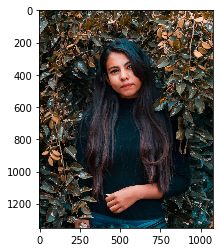

Human is Varsha R
/home/mluser/Documents/output__dataset/test/Varsha R/FB_IMG_1574318708952.jpg


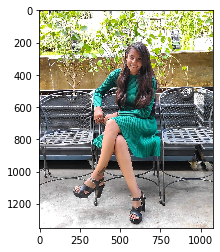

In [25]:
#Test predict_images
for img_file in os.listdir('/home/mluser/Documents/output__dataset/test/Varsha R/'):
    img_path = os.path.join('/home/mluser/Documents/output__dataset/test/Varsha R/', img_file)
    img=os.path.dirname('/home/mluser/Documents/output__dataset/test/Varsha R/')
    prediction = predict_images(img_file)
    folder=os.path.basename(img)
    print("image_file_name: {0}, \t prediction: {1}".format(img_path,folder))

#def run_app(img_path):
## handle cases for a human face, dog, and neither
def face_recognition(img_path):
    img=os.path.dirname('/home/mluser/Documents/output__dataset/test/Varsha R/')
    folder=os.path.basename(img)
    category = str(folder)
    print('Human is ' + category)
for img_file in os.listdir('/home/mluser/Documents/output__dataset/test/Varsha R/'):
    img_path = os.path.join('/home/mluser/Documents/output__dataset/test/Varsha R/', img_file)
    img=os.path.dirname('/home/mluser/Documents/output__dataset/test/Varsha R/')
    face_recognition(img_file)
    print(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()